<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

import random  

import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM, TimeDistributed, BatchNormalization, Bidirectional, Dense, Dropout
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import GRU
from keras.layers import *
from keras.utils.vis_utils import plot_model

import time

Using TensorFlow backend.


In [2]:
class RNN_train():
    """
    RNN  预测完整的 DOSE 分布
    200组 数据集，预处理后 输入： 200*240 输出： 200*240
    4 种模型选择 ， LSTM ，BiLSTM，GRU， BiGRU 
    """

    def __init__(self):
        self.UNITS = 32  # Units 数目
        self.EPOCHS = 200  # 训练循环数目
        self.TEST_SIZE = 0.2  # 数据集分割比例
        self.VAL = 0.2  # val 分割比例
        self.BATCH_SIZE = 32  # 一次训练多少组
        self.seed = 1340  # 随机数种子
        self.PATIENCE = 30  # 允许不降落步数
        self.OUTPUT_SIZE = 1  # 输入一个 输出 1个
        self.LR = 0.006  # 误差期望
        self.filepath1 = 'train_3.xlsx'  # 文件路径
        self.filepath2 = "Dose_inter_slinear.xlsx"

    def data_pre(self):
        """
        数据预处理 
        """
        df = pd.read_excel(self.filepath1)  # 读取文件
        training_set = DataFrame(df)
        training_set = training_set.T
        
        ct = pd.read_excel(self.filepath2,header= None)
        ct = np.array(ct)
        from sklearn.preprocessing import MinMaxScaler
        min_max_scaler = MinMaxScaler()
        ct_minmax = min_max_scaler.fit_transform(ct.T)

        ct = ct_minmax.T[:, :250]

        X_train_0 = training_set.iloc[:, :302].values
        y_train_0 = training_set.iloc[:, 302:].values
        X_train_0 = X_train_0[:, :250]
        y_train_0 = y_train_0[:, :250]  # 修建 0 值
        
        
        X_train_total = np.zeros((200,250,2))
        for i in range(200):
            X_train_total[i,:,0] = X_train_0[i,:]
        for i in range(200):
            X_train_total[i,:,1] = ct[i%10,:]

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_total,
            y_train_0,
            test_size=self.TEST_SIZE,
            random_state=self.seed)

        #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
        #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

        return X_train, y_train, X_test, y_test, X_train_total, y_train_0

    def LSTM_model(self):
        """
        构建 单层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            GRU(
                input_shape=(250, 2),
                units=self.UNITS,
                return_sequences=True,
                name="GRU"))

        #model.add(Dropout(0.10, name="dropout"))
        model.add(GRU(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model
    
    def BiLSTM_model(self):
        """
        构建 单层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            Bidirectional(LSTM(
                input_shape=(250, 2),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"),name ="BiGRU_1"))

        #model.add(Dropout(0.10, name="dropout_2"))
        
        
        model.add(
            Bidirectional(LSTM(
                input_shape=(250, 2),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_3"),name ="BiGRU_3"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model


    def LSTM_model_2(self):
        """
        构建 2层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            LSTM(
                input_shape=(250, 1),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"))

        model.add(Dropout(0.50, name="dropout_1"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(Dropout(0.50, name="dropout_2"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model

    def LSTM_model_3(self):
        """
        构建 3 层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            LSTM(
                input_shape=(250, 1),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"))

        model.add(Dropout(0.50, name="dropout_1"))
        model.add(GRU(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(Dropout(0.50, name="dropout_2"))
        model.add(GRU(units=self.UNITS, return_sequences=True, name="GRU_3"))
        model.add(Dropout(0.50, name="dropout_3"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model

    def LSTM_model_4(self):
        """
        构建 4 层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            LSTM(
                input_shape=(250, 1),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"))

        model.add(Dropout(0.50, name="dropout_1"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(Dropout(0.50, name="dropout_2"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_3"))
        model.add(Dropout(0.50, name="dropout_3"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_4"))
        model.add(Dropout(0.50, name="dropout_4"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model

    def LSTM_model_5(self):
        """
        构建 5 层双向 GRU 模型 
        """
        model = Sequential()
        model.add(
            LSTM(
                input_shape=(250, 1),
                units=self.UNITS,
                return_sequences=True,
                name="GRU_1"))

        model.add(Dropout(0.50, name="dropout_1"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_2"))
        model.add(Dropout(0.50, name="dropout_2"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_3"))
        model.add(Dropout(0.50, name="dropout_3"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_4"))
        model.add(Dropout(0.50, name="dropout_4"))
        model.add(LSTM(units=self.UNITS, return_sequences=True, name="GRU_5"))
        model.add(Dropout(0.50, name="dropout_5"))
        model.add(
            TimeDistributed(
                Dense(self.OUTPUT_SIZE, name="Dense"), name="TDense"))
        adam = Adam(self.LR)
        model.compile(
            optimizer=adam,
            loss='mse',
        )
        return model

    def model_train(self, model):
        """
        训练模型， 输入 compile 之后的模型 ，返回训练的模型
        """
        X_train, y_train, X_test, y_test, _, _ = self.data_pre()
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=self.PATIENCE, verbose=0, mode='min')
        history = model.fit(
            X_train,
            y_train,
            batch_size=self.BATCH_SIZE,
            epochs=self.EPOCHS,
            verbose=1,
            validation_split=self.VAL,  # 加入 交叉验证集
            callbacks=[early_stopping])

        return history, model

    def train_plot(self, history):
        """
        绘制 训练的 loss 和 val_loss 图
        """
        plt.figure(figsize=(20, 10))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.ylabel("loss", fontsize=30)
        plt.xlabel("epoch", fontsize=30)
        plt.legend(["train_loss", "val_loss"], loc="upper right")
        plt.show()

    def loss_cal(self, model):
        """
        计算 评估模型的指标  
        输入训练好的模型
        """
        X_train, y_train, X_test, y_test, _, _ = self.data_pre()
        N = X_test.shape[0]  # 测试数据的数目

        test_loss_total = []
        peak_loss_total = []
        peak_shift_total = []
        peak_half_loss_list = []
        peak_twenty_percent_loss_list = []

        for i in range(N):

            X_test[i] = np.array(X_test[i], dtype=float)
            y_test[i] = np.array(y_test[i], dtype=float)
            X_test_0 = X_test[i][np.newaxis, :, :]
            y_test_0 = y_test[i][np.newaxis, :, :]

            # 计算 测试集总误差

            y_test_0_pred = model.predict(X_test_0)
            test_loss = np.mean(np.square(y_test_0_pred - y_test_0))
            test_loss_total.append(test_loss)

            x_pre = model.predict(X_test_0)
            x_pre = x_pre.ravel()  # 调整形状
            x_pre = np.array(x_pre, dtype=np.float64)  # 调整 数据
            x_real = y_test_0.ravel()

            # 计算测试集 peak 偏移
            peak_shift = abs(np.argmax(x_real) - np.argmax(x_pre))
            peak_shift_total.append(peak_shift)

            # 转换为列表
            x_real_list = x_real.tolist()
            x_pre_list = x_pre.tolist()

            # 计算 测试集 距离峰值一半的偏差
            half_peak = x_real.max() * 0.5
            for j in x_real[:np.argmax(x_real)]:
                if j > half_peak or j == half_peak:
                    index_l1 = x_real_list.index(j)
                    break
            for j in x_real[np.argmax(x_real):]:
                if j < half_peak or j == half_peak:
                    index_r1 = x_real_list[np.argmax(x_real):].index(
                        j) + np.argmax(x_real)
                    break

            half_loss = [
                abs(x_real_list[i] - x_pre_list[i])
                for i in range(index_l1, index_r1)
            ]
            peak_half_loss = np.mean(np.square(half_loss))
            peak_half_loss_list.append(peak_half_loss)

            # 计算距离峰值 20% 的偏差
            twenty_percent_peak = x_real.max() * 0.2
            for i in x_real[:np.argmax(x_real)]:
                if i > twenty_percent_peak or i == twenty_percent_peak:
                    index_l2 = x_real_list.index(i)
                    break

            for i in x_real[np.argmax(x_real):]:
                if i < twenty_percent_peak or i == twenty_percent_peak:
                    index_r2 = x_real_list[np.argmax(x_real):].index(
                        i) + np.argmax(x_real)
                    break
            twenty_percent_loss = [
                abs(x_real_list[i] - x_pre_list[i])
                for i in range(index_l2, index_r2)
            ]
            peak_twenty_percent_loss = np.mean(np.square(twenty_percent_loss))
            peak_twenty_percent_loss_list.append(peak_twenty_percent_loss)

            i = i + 1

        peak_shift_MAE = np.mean(peak_shift_total)
        peak_shift_MSE = np.mean(np.square(peak_shift_total))
        peak_twenty_percent_loss_ave = np.mean(peak_twenty_percent_loss_list)
        peak_half_loss_ave = np.mean(peak_half_loss_list)
        test_loss_total_ave = np.mean(test_loss_total)

        return peak_shift_MAE, peak_shift_MSE, test_loss_total_ave,peak_half_loss_ave, peak_twenty_percent_loss_ave

    def curve_shift(self, model):

        X_train, y_train, X_test, y_test, _, _ = self.data_pre()

        per_average_total = []
        per50_average_total = []
        per20_average_total = []
        N = X_test.shape[0]

        for i in range(N):
            X_test[i] = np.array(X_test[i], dtype=float)
            y_test[i] = np.array(y_test[i], dtype=float)
            X_test_0 = X_test[i][np.newaxis, :, :]
            y_test_0 = y_test[i][np.newaxis, :, :]

            x_pre = model.predict(X_test_0, batch_size=1, verbose=0)
            x_pre = x_pre.ravel()  # 调整形状
            x_pre = np.array(x_pre, dtype=np.float64)  # 调整 数据
            x_real = y_test_0.ravel()

            # 计算曲线的 总偏移
            #curve_shift = x_real - x_pre
            per_list = []
            n = 0
            for i in range(240):
                if x_real[i] > 1e-3:
                    n = n + 1
                    a = abs(x_real[i] - x_pre[i]) / x_real[i]
                    per_list.append(a)
            per_average = sum(per_list) / n
            per_average_total.append(per_average)

            # 计算曲线的半高偏移

            # 转换为列表
            x_real_list = x_real.tolist()
            x_pre_list = x_pre.tolist()

            # 计算 测试集 距离峰值一半的偏差
            half_peak = x_real.max() * 0.5
            for j in x_real[:np.argmax(x_real)]:
                if j > half_peak or j == half_peak:
                    index_l1 = x_real_list.index(j)
                    break
            for j in x_real[np.argmax(x_real):]:
                if j < half_peak or j == half_peak:
                    index_r1 = x_real_list[np.argmax(x_real):].index(
                        j) + np.argmax(x_real)
                    break

            per50_list = [
                abs(x_real_list[i] - x_pre_list[i]) / x_real_list[i]
                for i in range(index_l1, index_r1)
            ]

            per50_average = sum(per50_list) / (index_r1 - index_l1)
            per50_average_total.append(per50_average)

            # 计算距离峰值 20% 的偏差
            twenty_percent_peak = x_real.max() * 0.2
            for i in x_real[:np.argmax(x_real)]:
                if i > twenty_percent_peak or i == twenty_percent_peak:
                    index_l2 = x_real_list.index(i)
                    break

            for i in x_real[np.argmax(x_real):]:
                if i < twenty_percent_peak or i == twenty_percent_peak:
                    index_r2 = x_real_list[np.argmax(x_real):].index(
                        i) + np.argmax(x_real)
                    break
            per20_list = [
                abs(x_real_list[i] - x_pre_list[i]) / x_real_list[i]
                for i in range(index_l2, index_r2)
            ]

            per20_average = sum(per20_list) / (index_r2 - index_l2)
            per20_average_total.append(per20_average)

            i = i + 1

        per100 = sum(per_average_total) / N
        per50 = sum(per50_average_total) / N
        per20 = sum(per20_average_total) / N

        return per100, per50, per20

Train on 128 samples, validate on 32 samples
Epoch 1/200
128/128 [==============================] - 5s 36ms/step - loss: 0.0652 - val_loss: 0.0409
Epoch 2/200
128/128 [==============================] - 2s 14ms/step - loss: 0.0324 - val_loss: 0.0163
Epoch 3/200
128/128 [==============================] - 2s 17ms/step - loss: 0.0210 - val_loss: 0.0167
Epoch 4/200
128/128 [==============================] - 2s 12ms/step - loss: 0.0155 - val_loss: 0.0161
Epoch 5/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 6/200
128/128 [==============================] - 2s 14ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 7/200
128/128 [==============================] - 2s 16ms/step - loss: 0.0109 - val_loss: 0.0085
Epoch 8/200
128/128 [==============================] - 2s 13ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 9/200
128/128 [==============================] - 1s 11ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 10/200
128/128 [===============

128/128 [==============================] - 1s 11ms/step - loss: 5.6575e-04 - val_loss: 6.9441e-04
Epoch 77/200
128/128 [==============================] - 1s 11ms/step - loss: 5.8031e-04 - val_loss: 7.8116e-04
Epoch 78/200
128/128 [==============================] - 1s 11ms/step - loss: 5.9803e-04 - val_loss: 7.1402e-04
Epoch 79/200
128/128 [==============================] - 1s 11ms/step - loss: 5.5414e-04 - val_loss: 6.2128e-04
Epoch 80/200
128/128 [==============================] - 1s 11ms/step - loss: 5.2111e-04 - val_loss: 7.0201e-04
Epoch 81/200
128/128 [==============================] - 1s 11ms/step - loss: 5.0724e-04 - val_loss: 8.4895e-04
Epoch 82/200
128/128 [==============================] - 1s 11ms/step - loss: 6.1622e-04 - val_loss: 6.9739e-04
Epoch 83/200
128/128 [==============================] - 1s 11ms/step - loss: 6.0352e-04 - val_loss: 6.3992e-04
Epoch 84/200
128/128 [==============================] - 1s 11ms/step - loss: 6.0603e-04 - val_loss: 9.5279e-04
Epoch 85/200
1

128/128 [==============================] - 2s 13ms/step - loss: 1.6587e-04 - val_loss: 1.8800e-04
Epoch 150/200
128/128 [==============================] - 2s 15ms/step - loss: 1.4724e-04 - val_loss: 1.5549e-04
Epoch 151/200
128/128 [==============================] - 2s 13ms/step - loss: 1.3190e-04 - val_loss: 1.6555e-04
Epoch 152/200
128/128 [==============================] - 2s 12ms/step - loss: 1.5302e-04 - val_loss: 2.2221e-04
Epoch 153/200
128/128 [==============================] - 2s 12ms/step - loss: 2.1169e-04 - val_loss: 2.5928e-04
Epoch 154/200
128/128 [==============================] - 2s 12ms/step - loss: 2.2076e-04 - val_loss: 2.2447e-04
Epoch 155/200
128/128 [==============================] - 2s 12ms/step - loss: 2.2101e-04 - val_loss: 1.8585e-04
Epoch 156/200
128/128 [==============================] - 2s 12ms/step - loss: 1.8550e-04 - val_loss: 2.6034e-04
Epoch 157/200
128/128 [==============================] - 2s 12ms/step - loss: 2.1278e-04 - val_loss: 1.7358e-04
Epoch 

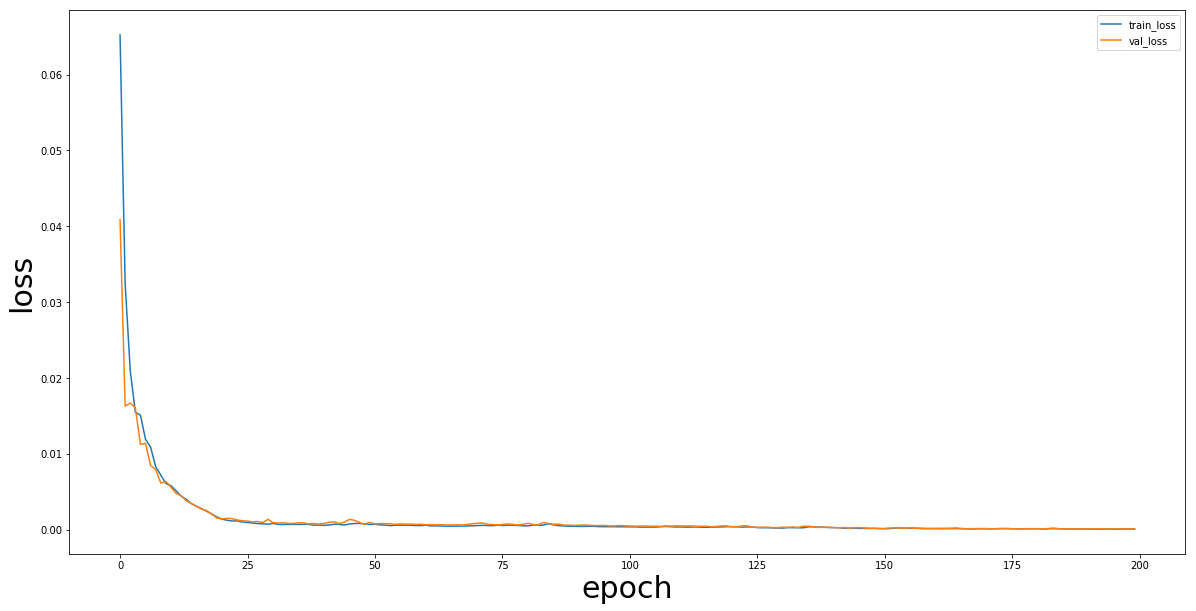

In [6]:
if __name__ == '__main__':
    RNN = RNN_train()
    model = RNN.BiLSTM_model()
    history, model = RNN.model_train(model)
    RNN.train_plot(history)

In [12]:
font = {
    'family': 'Times New Roman',
    'style': 'normal',
    'weight': 'bold',
    'size': 40
}

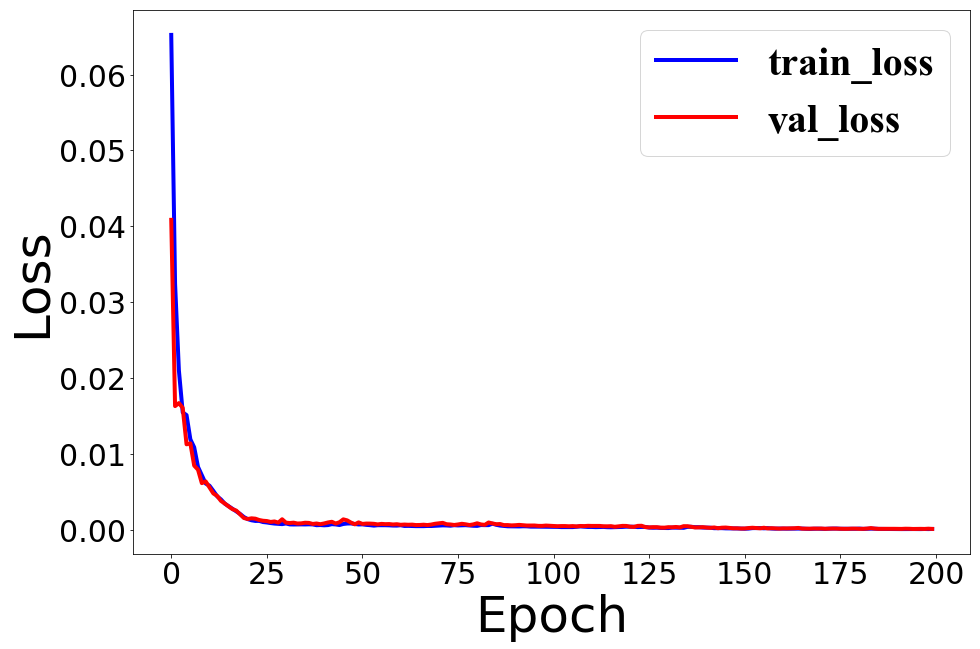

In [17]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], color='blue', lw=4, label='train_loss')
plt.plot(history.history['val_loss'],color='red', lw=4, label='val_loss')
plt.ylabel("Loss", fontsize=50)
plt.xlabel("Epoch", fontsize=50)
plt.xticks(fontsize="30")
plt.yticks(fontsize="30")
plt.legend(prop=font)

plt.savefig("Train_ct.png", bbox_inches='tight', dpi=100)
plt.show()

In [7]:
RNN.loss_cal(model)

(0.2, 0.2, 8.63166438007489e-05, 0.0006015918173965642, 0.00012993997666717335)

In [8]:
RNN.curve_shift(model)

(0.24893281669228756, 0.026112632022855558, 0.017466671531266707)

In [9]:
model.save("Nom_BiLSTM.h5")